In [3]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import shutil
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
# Importing all necessary libraries for image processing
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from tensorflow.keras.metrics import Accuracy, binary_crossentropy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
# Loading the text file
fold_df = pd.read_csv("./dataset/Folds.csv")

In [7]:
# Defining the paths
img_path = "./BreaKHis_v1/"
classes = ["benign", "malign"]

In [8]:
# Renaming the column filename to path
fold_df = fold_df.rename(columns={"filename": "path"})
# Printing the head of the file
fold_df.head(3)

fold  mag    grp                                               path
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...

In [9]:
# One example path is printed
fold_df['path'][0]

'BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png'

In [10]:
# Extracting the filename and label from the path column
fold_df['filename'] = fold_df['path'].apply(lambda x: x.split("/")[-1])
fold_df["label"] = fold_df['path'].apply(lambda x: x.split("/")[3])

In [11]:
fold_df.head(3)

fold  mag    grp                                               path  \
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   

                         filename   label  
0  SOB_B_A-14-22549AB-100-001.png  benign  
1  SOB_B_A-14-22549AB-100-002.png  benign  
2  SOB_B_A-14-22549AB-100-003.png  benign

In [ ]:
# Creating new directory
os.makedirs("./Breast-Cancer")

In [ ]:
# Move all images to one folder
for p in fold_df['path']:
    src = "./dataset/BreaKHis_v1/" + p
    dest = "./Breast-Cancer"
    # save the files with its corresponding class and patient_id
    # ERROR here causing extra "SOB_" to be added to filename
    dest = os.path.join(dest, src.split("/")[-1]) 
    shutil.copyfile(src, dest)

In [ ]:
# Checking the len
len(os.listdir("./Breast-Cancer/"))

7909

In [15]:
# Creating a new data frame with labels and file names stored in a single folder
fold_df["file_loc"] = fold_df['label'] + "_" + fold_df['filename']
# Encoding the class to integer
fold_df['class'] = fold_df['label'].apply(lambda x: 0 if x=='benign' else 1)

In [54]:
# Printing the head to display the changes made
fold_df.head(3)

fold  mag    grp                                               path  \
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   

                         filename   label  \
0  SOB_B_A-14-22549AB-100-001.png  benign   
1  SOB_B_A-14-22549AB-100-002.png  benign   
2  SOB_B_A-14-22549AB-100-003.png  benign   

                                file_loc  class  
0  benign_SOB_B_A-14-22549AB-100-001.png      0  
1  benign_SOB_B_A-14-22549AB-100-002.png      0  
2  benign_SOB_B_A-14-22549AB-100-003.png      0

Text(0.5, 1.0, 'No. of Patients Benign and Malignant')

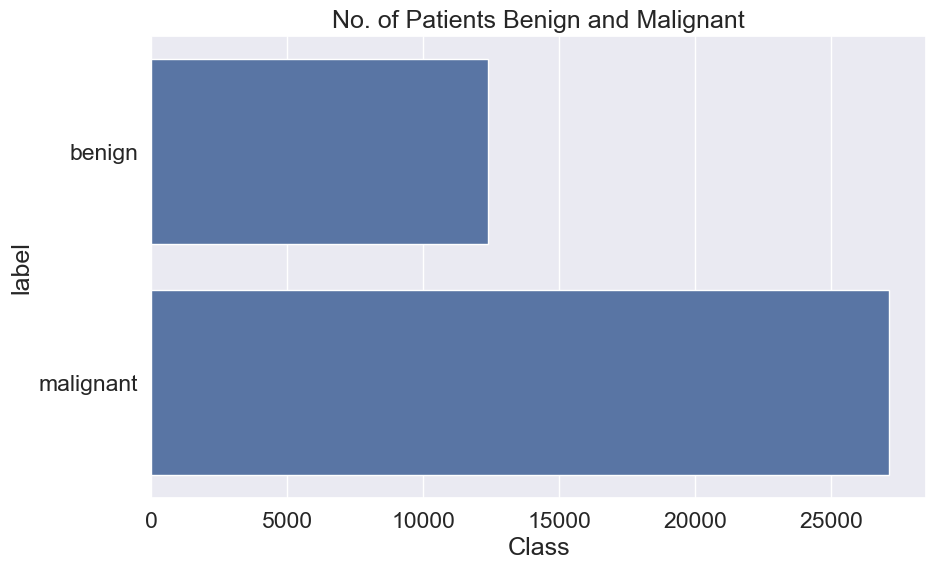

In [51]:
# Lets explore the data set
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.5)
sns.set_style("darkgrid")
sns.countplot(fold_df['label'])
plt.xlabel("Class")
plt.title("No. of Patients Benign and Malignant")

In [18]:
# Filtering the data frame to benign and malignant for visualization
benign_df = fold_df[fold_df['label'] == 'benign']
malignant_df = fold_df[fold_df['label'] == 'malignant']

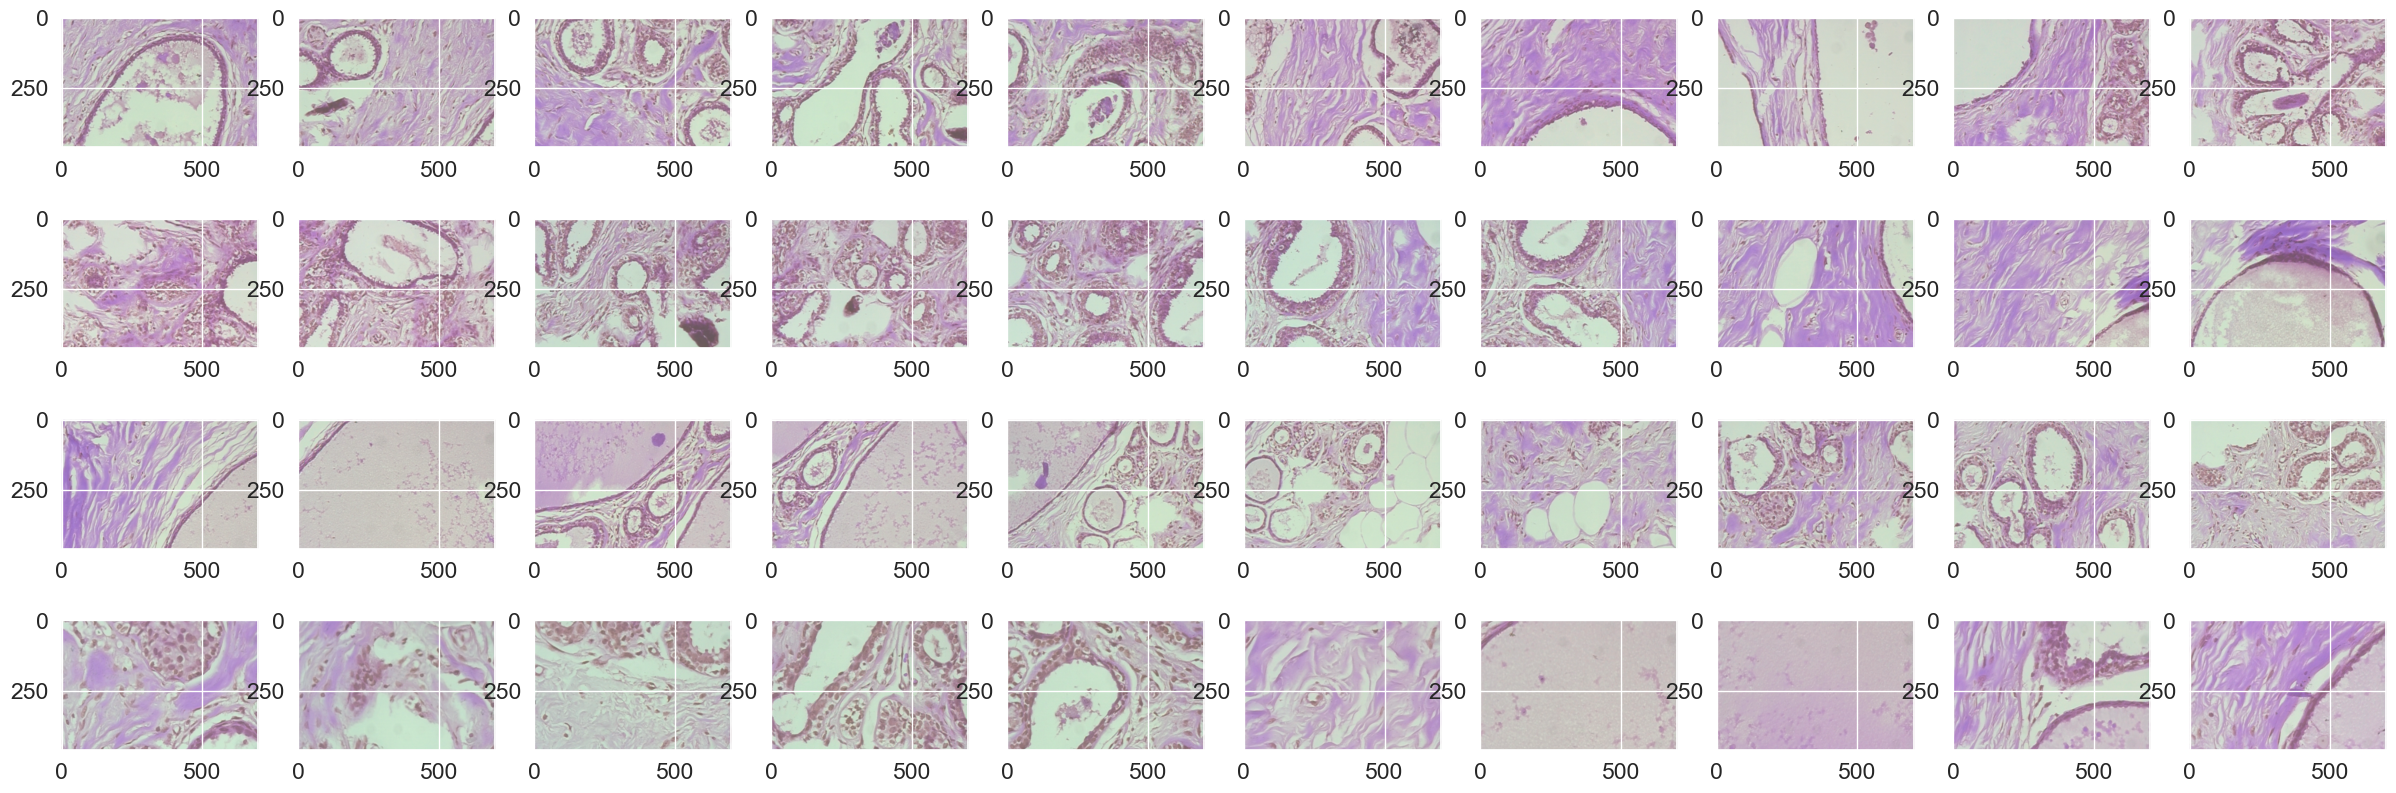

In [ ]:
# Plotting the benign samples
plt.figure(figsize=(30, 10))
for i in range(0, 40):
    plt.subplot(4, 10, i+1)
    # for some reason, my files got added with an extra "SOB_" at the beginning
    img = cv2.imread("./Breast-Cancer/" + benign_df['file_loc'][i].split("benign_")[1], 1)
    plt.imshow(img)

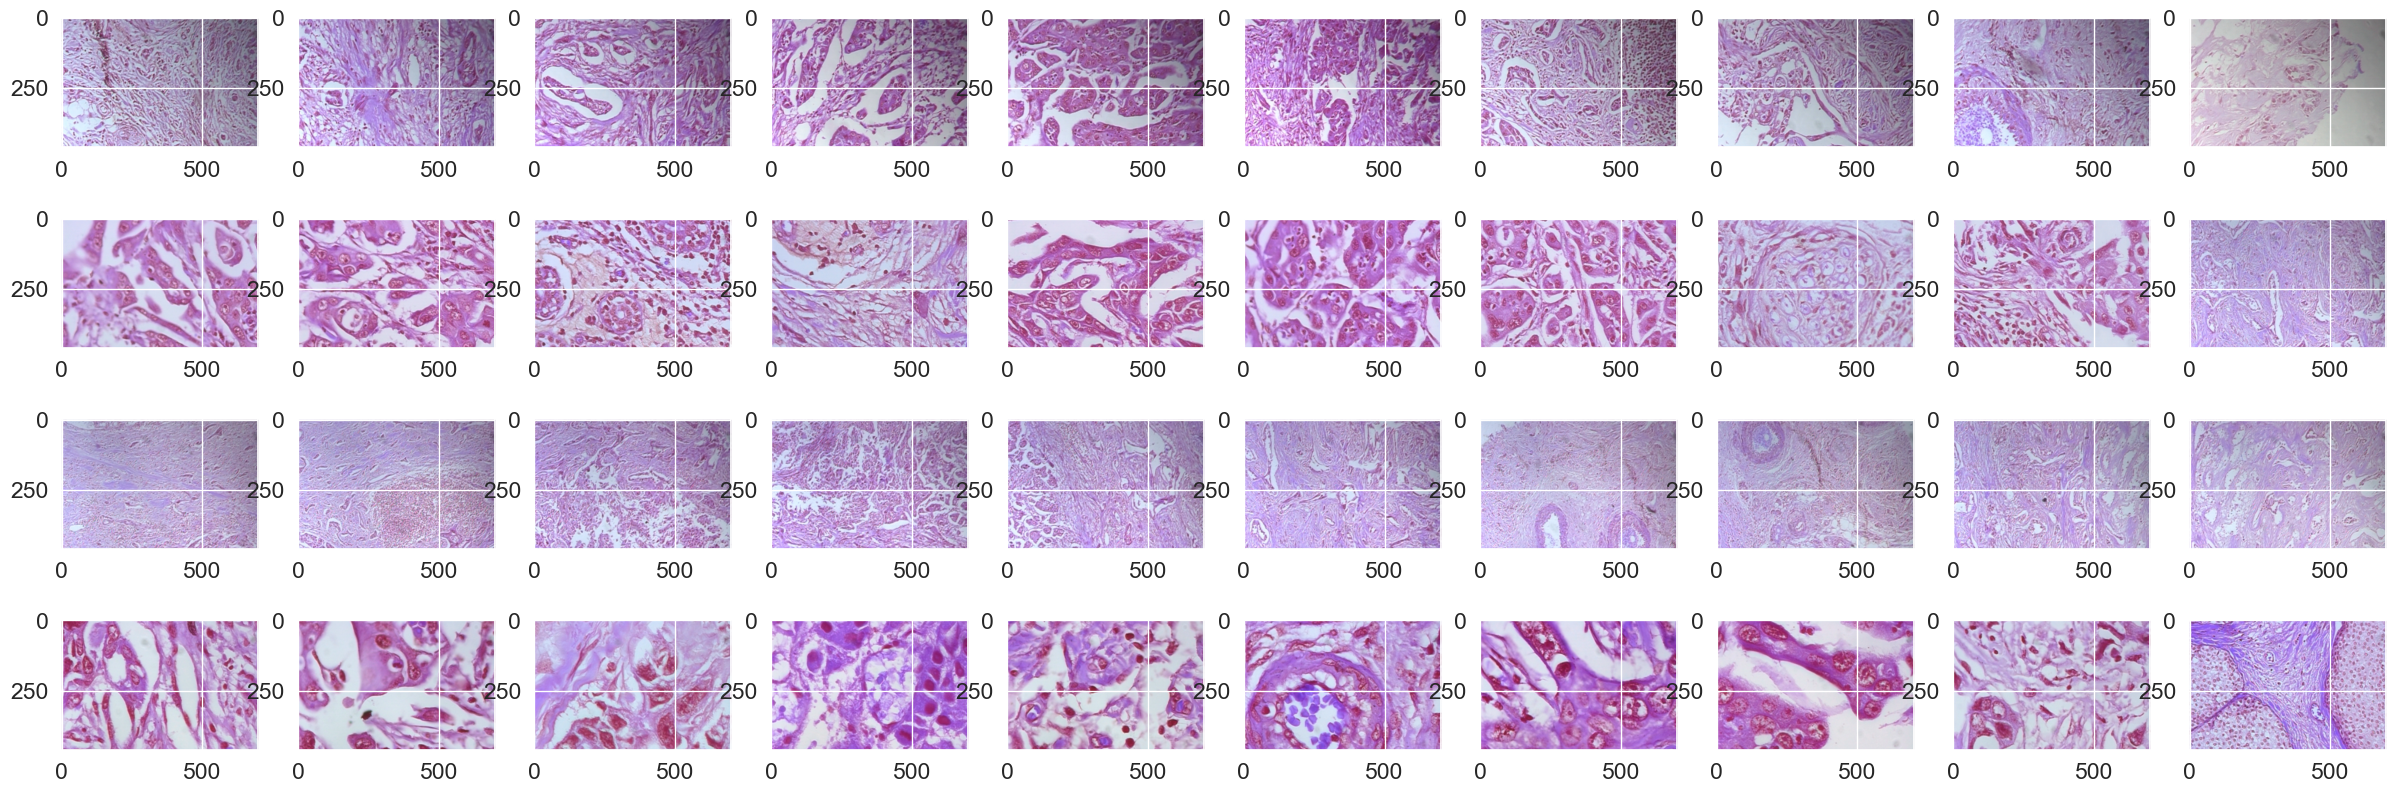

In [ ]:
# Plotting the malignant samples
images = malignant_df['file_loc'].values
plt.figure(figsize=(30, 10))
for i in range(0, 40):
    plt.subplot(4, 10, i+1)
    img = cv2.imread("./Breast-Cancer/" + images[i].split("malignant_")[1], 1)
    plt.imshow(img)

In [ ]:
# Creating a new data frame with the file loc as its index, label and class of the patients as its columns
df = pd.DataFrame(os.listdir("./Breast-Cancer/"))
df = df.rename(columns = {0:'file_loc'})
df['label'] = df['file_loc'].apply(lambda x: "benign" if x.split("_")[1] == "B" else "malignant")
df['class'] = df['label'].apply(lambda x: 0 if x=='benign' else 1)
df.set_index('file_loc', inplace=True)

In [81]:
# Checking the new data frame
df.head(2)

label  class
file_loc                                     
SOB_B_A-14-22549AB-100-001.png  benign      0
SOB_B_A-14-22549AB-100-002.png  benign      0

In [82]:
# Perform the splitting
data_train_and_val, data_test = train_test_split(df, test_size=0.1, random_state=35)
# Training and val
data_train, data_val = train_test_split(data_train_and_val, test_size=0.1, random_state=35)

In [83]:
print("Training size: ", data_train.shape)
print("Validation size: ", data_val.shape)
print("Testing size: ", data_test.shape)

Training size:  (6406, 2)
Validation size:  (712, 2)
Testing size:  (791, 2)


Text(0.5, 1.0, 'Test set')

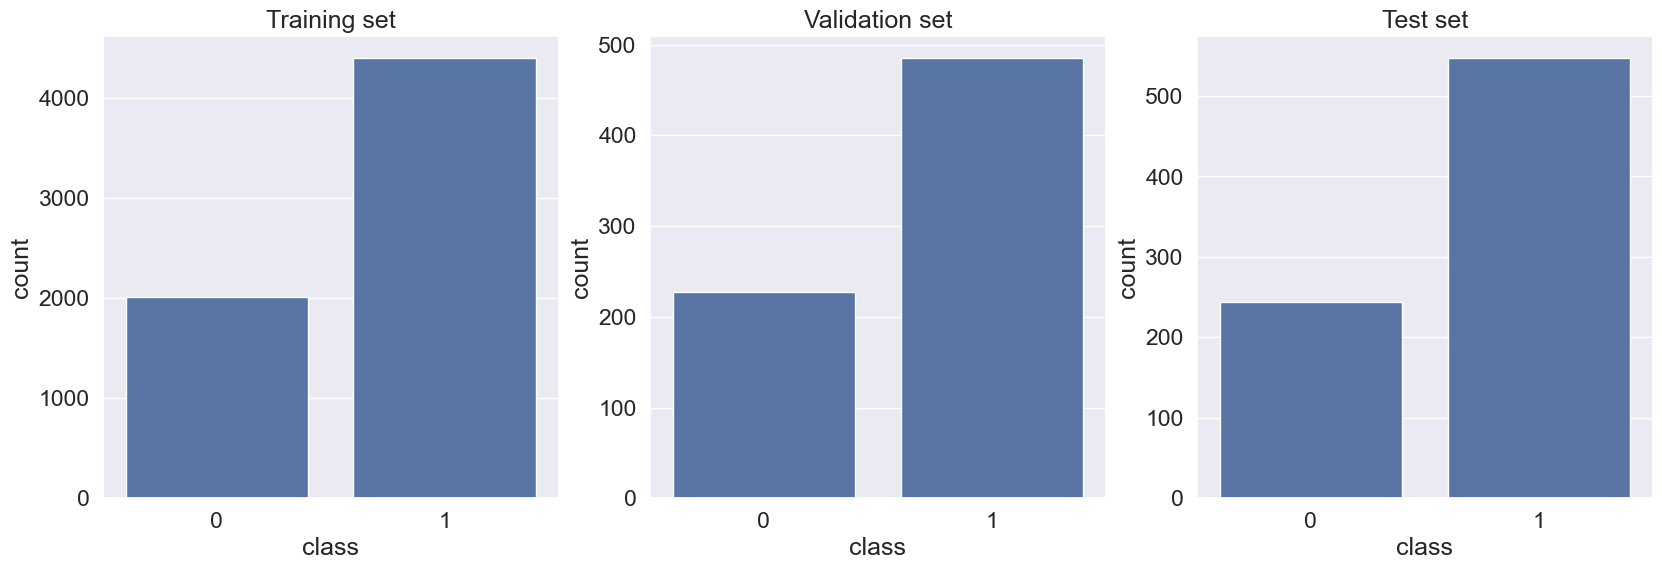

In [89]:
#Plotting
sns.set_style("darkgrid")
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
sns.countplot(x='class', data=data_train)
plt.title("Training set")
plt.subplot(1,3,2)
sns.countplot(x='class', data=data_val)
plt.title("Validation set")
plt.subplot(1,3,3)
sns.countplot(x='class', data=data_test)
plt.title("Test set")

- Training , Validation and Testing data is pretty imbalanced as this is the case in the real world.
- Here the validation and testing set is left as it is, because it should reflects the real world scenario.
- And the training data is balanced by oversampling the minority class(Benign).

In [90]:
# Separating the benign and malignant patients from train data
train_has_cancer = data_train[data_train['class']==1]
train_has_no_cancer = data_train[data_train['class']==0]

In [91]:
train_has_cancer.shape

(4397, 2)

In [92]:
train_has_no_cancer.shape

(2009, 2)

In [93]:
# Upsampling the minority class by the size of majority class with replacement
train_has_no_cancer_upsample = resample(train_has_no_cancer, n_samples=len(train_has_cancer), random_state=35, replace=True)

In [94]:
# Concatenating the upsampled minority class and the majority class
data_train = pd.concat([train_has_cancer, train_has_no_cancer_upsample])

Text(0.5, 1.0, 'Test set')

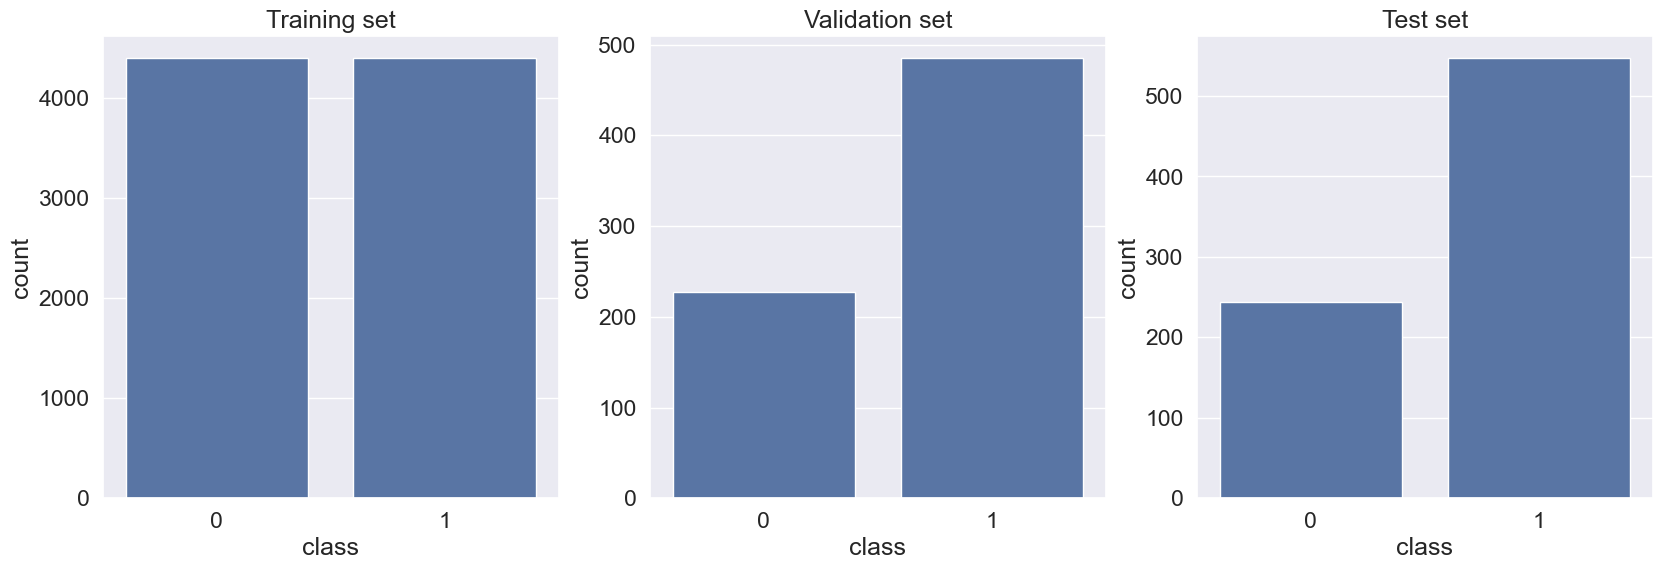

In [95]:
sns.set_style("darkgrid")
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
sns.countplot(x='class', data=data_train)
plt.title("Training set")
plt.subplot(1,3,2)
sns.countplot(x='class', data=data_val)
plt.title("Validation set")
plt.subplot(1,3,3)
sns.countplot(x='class', data=data_test)
plt.title("Test set")

In [96]:
# Creating the directories to store images
# Training data
os.makedirs("./Breast-Cancer_train")
os.makedirs("./Breast-Cancer_train/benign")
os.makedirs("./Breast-Cancer_train/malignant")
# Validation data
os.makedirs("./Breast-Cancer_validation")
os.makedirs("./Breast-Cancer_validation/benign")
os.makedirs("./Breast-Cancer_validation/malignant")
# Testing data
os.makedirs("./Breast-Cancer_test")
os.makedirs("./Breast-Cancer_test/benign")
os.makedirs("./Breast-Cancer_test/malignant")

In [97]:
# Training data
i = 1
for img in data_train.index:
    if img != ".DS_Store":
        target = df.loc[img, 'class']
        if target == 1:
            label = 'malignant'
        else:
            label = 'benign'
        src = os.path.join("./Breast-Cancer/", img)
        dest = os.path.join("./Breast-Cancer_train/", label, "image" + str(i) + ".png")
        img1 = np.array(cv2.imread(src))
        cv2.imwrite(dest, img1)
        i = i+1

In [98]:
# Validation data
for img in data_val.index:
    target = data_val.loc[img, 'class']
    if target == 1:
        label = 'malignant'
    else:
        label = 'benign'
    src = os.path.join("./Breast-Cancer/", img)
    dest = os.path.join("./Breast-Cancer_validation/", label, img)
    shutil.copyfile(src, dest)

In [99]:
# Testing data
for img in data_test.index:
    target = data_test.loc[img, 'class']
    if target == 1:
        label = 'malignant'
    else:
        label = 'benign'
    src = os.path.join("./Breast-Cancer/", img)
    dest = os.path.join("./Breast-Cancer_test/", label, img)
    shutil.copyfile(src, dest)

In [100]:
# Checking their lengths
print("Training Data:")
print("Benign:", len(os.listdir("./Breast-Cancer_train/benign/")))
print("Malignant:", len(os.listdir("./Breast-Cancer_train/malignant/")))
print()
print("Validation Data:")
print("Benign:", len(os.listdir("./Breast-Cancer_validation/benign/")))
print("Malignant:", len(os.listdir("./Breast-Cancer_validation/malignant/")))
print()
print("Testing Data:")
print("Benign:", len(os.listdir("./Breast-Cancer_test/benign/")))
print("Malignant:", len(os.listdir("./Breast-Cancer_test/malignant/")))

Training Data:
Benign: 4397
Malignant: 4397

Validation Data:
Benign: 227
Malignant: 485

Testing Data:
Benign: 244
Malignant: 547


# Image Data Generator

In [101]:
# Defining Image Data Generator
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    shear_range=0.2,
    fill_mode = 'nearest',
    zoom_range=0.2
)

In [102]:
# Setting up the images for image data generator
train_generation = datagen.flow_from_directory("./Breast-Cancer_train/", target_size=(128, 128), batch_size=32, class_mode="binary")
val_generation = datagen.flow_from_directory("./Breast-Cancer_validation/", target_size=(128, 128), batch_size=32, class_mode="binary")

Found 8794 images belonging to 2 classes.
Found 712 images belonging to 2 classes.


# CNN Architecture

In [103]:
# Defining the base model
cancer_model = Sequential()

# First Layer
cancer_model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(128,128,3), activation='relu'))
cancer_model.add(MaxPooling2D(pool_size=(2,2)))

# Second Layer
cancer_model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
cancer_model.add(MaxPooling2D(pool_size=(2,2)))

# Third Layer
cancer_model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
cancer_model.add(MaxPooling2D(pool_size=(2,2)))
cancer_model.add(Dropout(0.4))

# Fourth Layer
cancer_model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
cancer_model.add(MaxPooling2D(pool_size=(2,2)))
cancer_model.add(Dropout(0.2))

# Flattening the layers
cancer_model.add(Flatten())

# Adding Dense Layer
cancer_model.add(Dense(256, activation='relu'))
cancer_model.add(Dense(128, activation='relu'))
cancer_model.add(Dense(1, activation='sigmoid'))

cancer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 128)      0

In [104]:
# Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=20*50,
    decay_rate=1,
    staircase=False
)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

# Model Compilation

In [105]:
# Compiling the model
cancer_model.compile(loss='binary_crossentropy', optimizer=get_optimizer(), metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint("./Best_model/", save_best_only=True)

# Model Fit

In [106]:
# Model is fitted using train and validation generator for 200 epochs
history = cancer_model.fit(
    train_generation, 
    validation_data=val_generation, 
    epochs=200, 
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/200
275/275 [==============================] - ETA: 0s - loss: 0.5431 - accuracy: 0.7474

INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 199s 722ms/step - loss: 0.5431 - accuracy: 0.7474 - val_loss: 0.4565 - val_accuracy: 0.8399
Epoch 2/200
275/275 [==============================] - ETA: 0s - loss: 0.4799 - accuracy: 0.7896

INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 129s 468ms/step - loss: 0.4799 - accuracy: 0.7896 - val_loss: 0.4440 - val_accuracy: 0.8399
Epoch 3/200
275/275 [==============================] - ETA: 0s - loss: 0.4566 - accuracy: 0.8058

INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 130s 474ms/step - loss: 0.4566 - accuracy: 0.8058 - val_loss: 0.4051 - val_accuracy: 0.8371
Epoch 4/200
275/275 [==============================] - ETA: 0s - loss: 0.4190 - accuracy: 0.8301

INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 137s 498ms/step - loss: 0.4190 - accuracy: 0.8301 - val_loss: 0.4046 - val_accuracy: 0.8455
Epoch 5/200
275/275 [==============================] - ETA: 0s - loss: 0.3986 - accuracy: 0.8372

INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 130s 471ms/step - loss: 0.3986 - accuracy: 0.8372 - val_loss: 0.3837 - val_accuracy: 0.8567
Epoch 6/200
275/275 [==============================] - 131s 478ms/step - loss: 0.3872 - accuracy: 0.8393 - val_loss: 0.4314 - val_accuracy: 0.8202
Epoch 7/200
275/275 [==============================] - ETA: 0s - loss: 0.3633 - accuracy: 0.8502

INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 143s 521ms/step - loss: 0.3633 - accuracy: 0.8502 - val_loss: 0.3569 - val_accuracy: 0.8680
Epoch 8/200
275/275 [==============================] - 132s 480ms/step - loss: 0.3624 - accuracy: 0.8527 - val_loss: 0.3717 - val_accuracy: 0.8581
Epoch 9/200
275/275 [==============================] - ETA: 0s - loss: 0.3403 - accuracy: 0.8579

INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 126s 458ms/step - loss: 0.3403 - accuracy: 0.8579 - val_loss: 0.3245 - val_accuracy: 0.8750
Epoch 10/200
275/275 [==============================] - 132s 479ms/step - loss: 0.3156 - accuracy: 0.8699 - val_loss: 0.3279 - val_accuracy: 0.8694
Epoch 11/200
275/275 [==============================] - ETA: 0s - loss: 0.3071 - accuracy: 0.8716

INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 134s 488ms/step - loss: 0.3071 - accuracy: 0.8716 - val_loss: 0.3221 - val_accuracy: 0.8610
Epoch 12/200
275/275 [==============================] - ETA: 0s - loss: 0.2932 - accuracy: 0.8773

INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 129s 469ms/step - loss: 0.2932 - accuracy: 0.8773 - val_loss: 0.2831 - val_accuracy: 0.8778
Epoch 13/200
275/275 [==============================] - 134s 489ms/step - loss: 0.2770 - accuracy: 0.8837 - val_loss: 0.3077 - val_accuracy: 0.8680
Epoch 14/200
275/275 [==============================] - 126s 460ms/step - loss: 0.2688 - accuracy: 0.8884 - val_loss: 0.2848 - val_accuracy: 0.8862
Epoch 15/200
275/275 [==============================] - ETA: 0s - loss: 0.2639 - accuracy: 0.8902

INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 145s 527ms/step - loss: 0.2639 - accuracy: 0.8902 - val_loss: 0.2801 - val_accuracy: 0.8722
Epoch 16/200
275/275 [==============================] - ETA: 0s - loss: 0.2500 - accuracy: 0.8957

INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 150s 543ms/step - loss: 0.2500 - accuracy: 0.8957 - val_loss: 0.2578 - val_accuracy: 0.8834
Epoch 17/200
275/275 [==============================] - 131s 475ms/step - loss: 0.2473 - accuracy: 0.8958 - val_loss: 0.2917 - val_accuracy: 0.8792
Epoch 18/200
275/275 [==============================] - 131s 475ms/step - loss: 0.2380 - accuracy: 0.8999 - val_loss: 0.3047 - val_accuracy: 0.8764
Epoch 19/200
275/275 [==============================] - 146s 530ms/step - loss: 0.2286 - accuracy: 0.9061 - val_loss: 0.2735 - val_accuracy: 0.8876
Epoch 20/200
275/275 [==============================] - 134s 488ms/step - loss: 0.2206 - accuracy: 0.9110 - val_loss: 0.3291 - val_accuracy: 0.8610
Epoch 21/200
275/275 [==============================] - ETA: 0s - loss: 0.2113 - accuracy: 0.9139

INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 130s 472ms/step - loss: 0.2113 - accuracy: 0.9139 - val_loss: 0.2284 - val_accuracy: 0.9031
Epoch 22/200
275/275 [==============================] - 137s 497ms/step - loss: 0.2105 - accuracy: 0.9145 - val_loss: 0.2444 - val_accuracy: 0.9087
Epoch 23/200
275/275 [==============================] - 137s 497ms/step - loss: 0.2019 - accuracy: 0.9190 - val_loss: 0.2383 - val_accuracy: 0.9003
Epoch 24/200
275/275 [==============================] - ETA: 0s - loss: 0.1870 - accuracy: 0.9239

INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 129s 470ms/step - loss: 0.1870 - accuracy: 0.9239 - val_loss: 0.2244 - val_accuracy: 0.9003
Epoch 25/200
275/275 [==============================] - 141s 511ms/step - loss: 0.1836 - accuracy: 0.9248 - val_loss: 0.2385 - val_accuracy: 0.8989
Epoch 26/200
275/275 [==============================] - 137s 497ms/step - loss: 0.1901 - accuracy: 0.9230 - val_loss: 0.2340 - val_accuracy: 0.9045
Epoch 27/200
275/275 [==============================] - 127s 463ms/step - loss: 0.1713 - accuracy: 0.9336 - val_loss: 0.2432 - val_accuracy: 0.9003
Epoch 28/200
275/275 [==============================] - 135s 491ms/step - loss: 0.1729 - accuracy: 0.9311 - val_loss: 0.2314 - val_accuracy: 0.9129
Epoch 29/200
275/275 [==============================] - ETA: 0s - loss: 0.1724 - accuracy: 0.9287

INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 153s 556ms/step - loss: 0.1724 - accuracy: 0.9287 - val_loss: 0.2160 - val_accuracy: 0.9073
Epoch 30/200
275/275 [==============================] - 126s 460ms/step - loss: 0.1709 - accuracy: 0.9318 - val_loss: 0.2371 - val_accuracy: 0.9017
Epoch 31/200
275/275 [==============================] - 137s 500ms/step - loss: 0.1721 - accuracy: 0.9314 - val_loss: 0.2300 - val_accuracy: 0.8989
Epoch 32/200
275/275 [==============================] - 132s 478ms/step - loss: 0.1637 - accuracy: 0.9344 - val_loss: 0.2430 - val_accuracy: 0.8961
Epoch 33/200
275/275 [==============================] - 124s 450ms/step - loss: 0.1619 - accuracy: 0.9356 - val_loss: 0.2349 - val_accuracy: 0.9101
Epoch 34/200
275/275 [==============================] - ETA: 0s - loss: 0.1512 - accuracy: 0.9403

INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 127s 460ms/step - loss: 0.1512 - accuracy: 0.9403 - val_loss: 0.2125 - val_accuracy: 0.9129
Epoch 35/200
275/275 [==============================] - ETA: 0s - loss: 0.1530 - accuracy: 0.9394

INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 124s 450ms/step - loss: 0.1530 - accuracy: 0.9394 - val_loss: 0.2059 - val_accuracy: 0.9129
Epoch 36/200
275/275 [==============================] - 119s 434ms/step - loss: 0.1529 - accuracy: 0.9388 - val_loss: 0.2092 - val_accuracy: 0.9143
Epoch 37/200
275/275 [==============================] - ETA: 0s - loss: 0.1468 - accuracy: 0.9412

INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 125s 456ms/step - loss: 0.1468 - accuracy: 0.9412 - val_loss: 0.2046 - val_accuracy: 0.9045
Epoch 38/200
275/275 [==============================] - 119s 433ms/step - loss: 0.1477 - accuracy: 0.9422 - val_loss: 0.2202 - val_accuracy: 0.9129
Epoch 39/200
275/275 [==============================] - 117s 426ms/step - loss: 0.1393 - accuracy: 0.9427 - val_loss: 0.2111 - val_accuracy: 0.9129
Epoch 40/200
275/275 [==============================] - ETA: 0s - loss: 0.1433 - accuracy: 0.9420

INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 123s 447ms/step - loss: 0.1433 - accuracy: 0.9420 - val_loss: 0.2036 - val_accuracy: 0.9101
Epoch 41/200
275/275 [==============================] - 119s 433ms/step - loss: 0.1385 - accuracy: 0.9444 - val_loss: 0.2215 - val_accuracy: 0.9073
Epoch 42/200
275/275 [==============================] - 127s 462ms/step - loss: 0.1331 - accuracy: 0.9466 - val_loss: 0.2094 - val_accuracy: 0.9129
Epoch 43/200
275/275 [==============================] - ETA: 0s - loss: 0.1321 - accuracy: 0.9474

INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 134s 487ms/step - loss: 0.1321 - accuracy: 0.9474 - val_loss: 0.1964 - val_accuracy: 0.9270
Epoch 44/200
275/275 [==============================] - 126s 458ms/step - loss: 0.1362 - accuracy: 0.9467 - val_loss: 0.2038 - val_accuracy: 0.9115
Epoch 45/200
275/275 [==============================] - 125s 453ms/step - loss: 0.1284 - accuracy: 0.9485 - val_loss: 0.2095 - val_accuracy: 0.9059
Epoch 46/200
275/275 [==============================] - 134s 489ms/step - loss: 0.1269 - accuracy: 0.9499 - val_loss: 0.2204 - val_accuracy: 0.9129
Epoch 47/200
275/275 [==============================] - 131s 475ms/step - loss: 0.1282 - accuracy: 0.9483 - val_loss: 0.2384 - val_accuracy: 0.9101
Epoch 48/200
275/275 [==============================] - 126s 457ms/step - loss: 0.1265 - accuracy: 0.9501 - val_loss: 0.2080 - val_accuracy: 0.9199


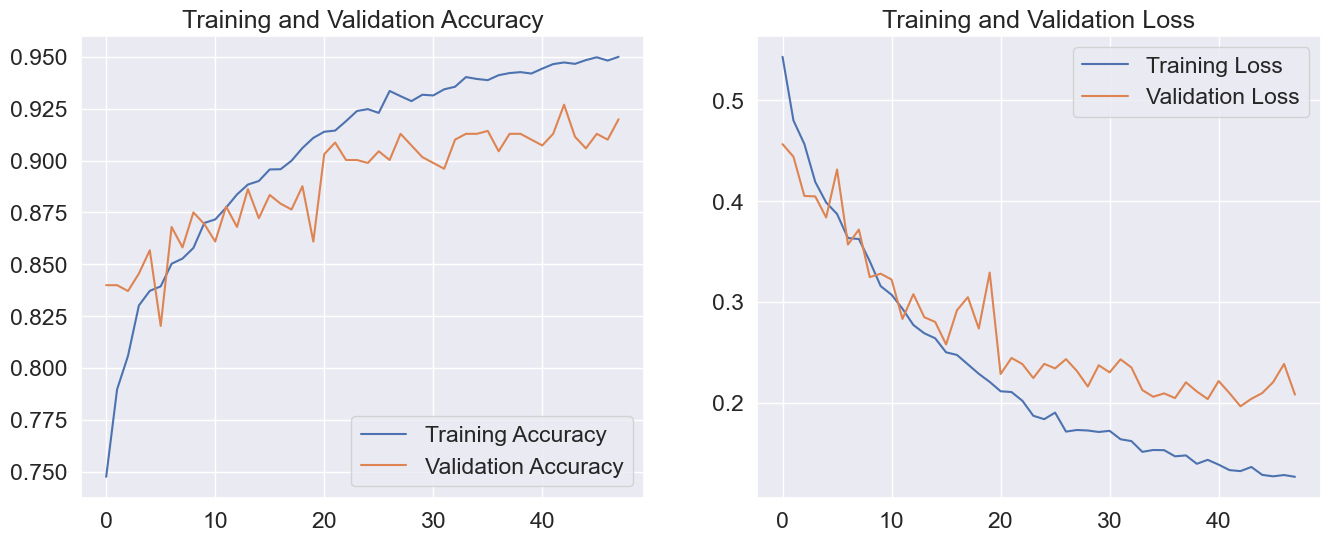

In [107]:
# Plotting the model results

# Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

# No of epochs it trained
epochs_range = history.epoch

# Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

# Plotting Training and Validation Loss
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")
plt.show()

# Evaluation on Test Data

In [108]:
# Loading the test data using Image Data Generator
test_gen = datagen.flow_from_directory("./Breast-Cancer_test/", target_size=(128,128), class_mode="binary", batch_size=1, shuffle=False)

Found 791 images belonging to 2 classes.


In [109]:
pred = cancer_model.evaluate(test_gen)

791/791 [==============================] - 19s 24ms/step - loss: 0.1846 - accuracy: 0.9355


In [110]:
# Let's go ahead and test our model for few Images.

# Array to hold Input Images and their labels
test = []
labels = []

# Loading random 10 images
random_images = np.random.choice(data_test.index, 10)

# For loop to read and store images
for i in random_images:
    # Finding their class to load from folder
    label = data_test.loc[i, "class"]
    labels.append(label)
    if label == 1:
        lab = 'malignant'
    else:
        lab = 'benign'
    # Creating path
    path = os.path.join("./Breast-Cancer_test/", lab, i)
    # reading image
    img = cv2.imread(path)
    # resizing to target shape
    img = cv2.resize(img, (128,128))
    # making it an numpy array
    img = np.array(img)
    # appending it to the list
    test.append(img)

# Making the list as numpy array
test = np.asarray(test)
# rescaling it by pixel value
test = test/255.

In [111]:
# Performing the prediction
pred = (cancer_model.predict(test) > 0.5).astype("int32")
# Flattening the list to form single dimensional list
pred = pred.flatten()

1/1 [==============================] - 0s 154ms/step


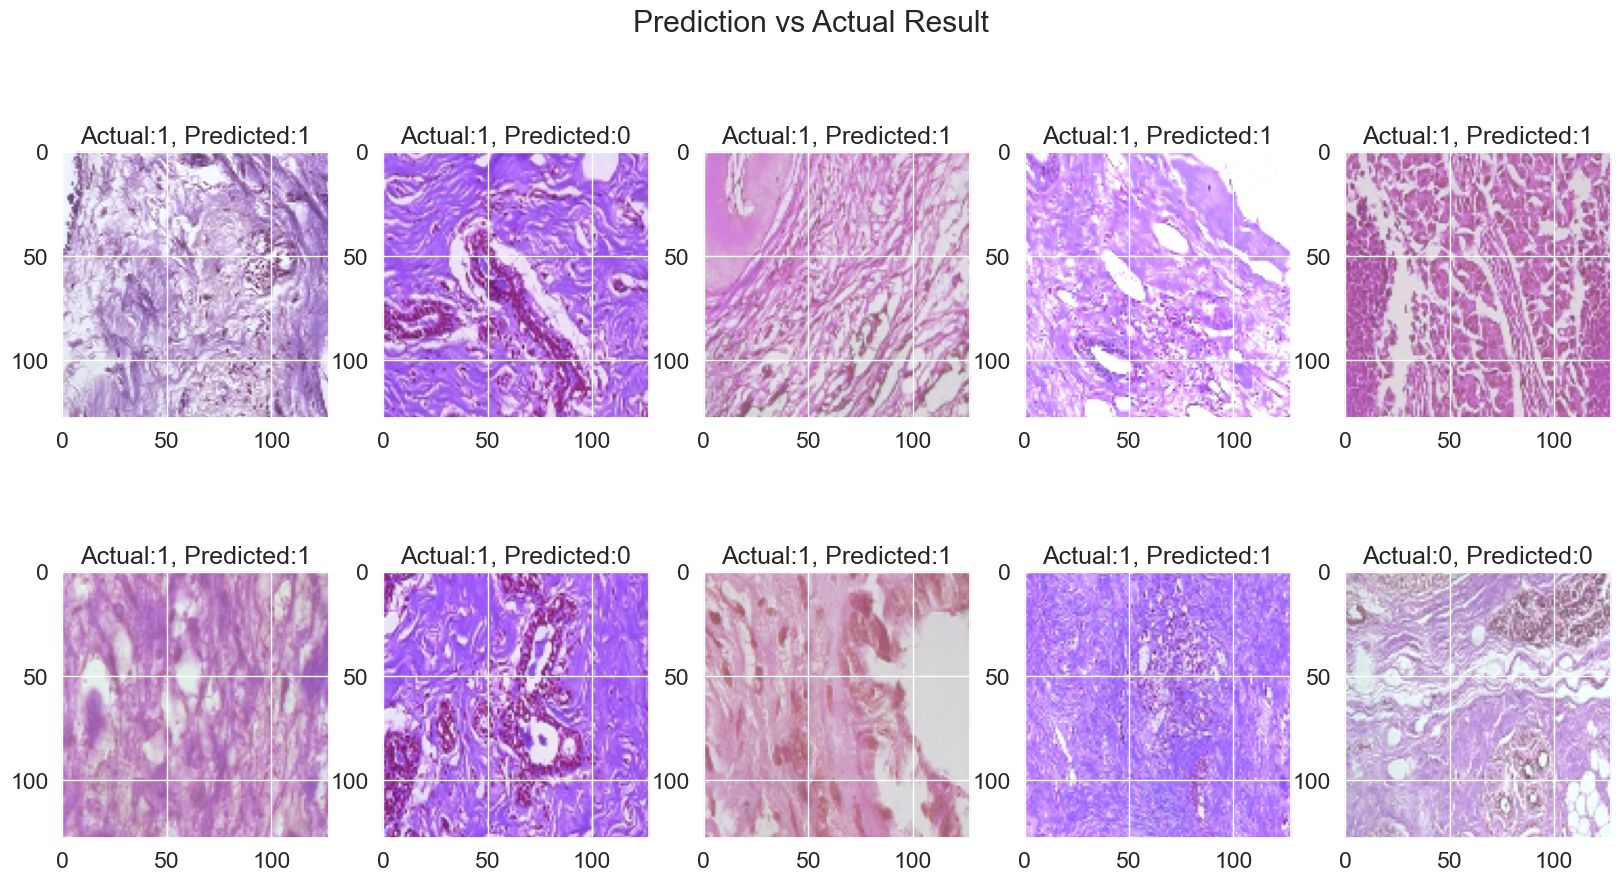

In [113]:
# Plotting the results and actual prediction
plt.figure(figsize=(20, 10))
plt.suptitle("Prediction vs Actual Result")
for i in range(0, 10):
    string = "Actual:" + str(labels[i]) + ", Predicted:" + str(pred[i])
    plt.subplot(2,5,i+1)
    plt.imshow(test[i])
    plt.title(string)